# LangSmith and Evaluation Overview with AI Makerspace

Today we'll be looking at an amazing tool:

[LangSmith](https://docs.smith.langchain.com/)!

This tool will help us monitor, test, debug, and evaluate our LangChain applications - and more!

We'll also be looking at a few Advanced Retrieval techniques along the way - and evaluate it using LangSmith!

✋BREAKOUT ROOM #2:
- Task 1: Dependencies and OpenAI API Key
- Task 2: LCEL RAG Chain
- Task 3: Setting Up LangSmith
- Task 4: Examining the Trace in LangSmith!
- Task 5: Create Testing Dataset
- Task 6: Evaluation

## Task 1: Dependencies and OpenAI API Key

We'll be using OpenAI's suite of models today to help us generate and embed our documents for a simple RAG system built on top of LangChain's blogs!

In [6]:
!pip install langchain_core langchain_openai langchain_community langchain-qdrant qdrant-client langsmith openai tiktoken cohere lxml -qU

In [23]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

#### Asyncio Bug Handling

This is necessary for Colab.

In [24]:
import nest_asyncio
nest_asyncio.apply()

## Task #2: Create a Simple RAG Application Using Qdrant, Hugging Face, and LCEL

Now that we have a grasp on how LCEL works, and how we can use LangChain and Hugging Face to interact with our data - let's step it up a notch and incorporate Qdrant!

## LangChain Powered RAG

First and foremost, LangChain provides a convenient way to store our chunks and their embeddings.

It's called a `VectorStore`!

We'll be using QDrant as our `VectorStore` today. You can read more about it [here](https://qdrant.tech/documentation/).

Think of a `VectorStore` as a smart way to house your chunks and their associated embedding vectors. The implementation of the `VectorStore` also allows for smarter and more efficient search of our embedding vectors - as the method we used above would not scale well as we got into the millions of chunks.

Otherwise, the process remains relatively similar under the hood!

We'll use a SiteMapLoader to scrape the LangChain blogs - which will serve as our data for today!

### Data Collection

We'll be leveraging the `SitemapLoader` to load our PDF directly from the web!

In [3]:
from langchain.document_loaders import SitemapLoader

documents = SitemapLoader(web_path="https://blog.langchain.dev/sitemap-posts.xml").load()

USER_AGENT environment variable not set, consider setting it to identify your requests.
Fetching pages: 100%|##########| 220/220 [00:47<00:00,  4.68it/s]


In [5]:
!pip install bs4

  Using cached beautifulsoup4-4.12.3-py3-none-any.whl.metadata (3.8 kB)
Using cached beautifulsoup4-4.12.3-py3-none-any.whl (147 kB)


### Chunking Our Documents

Let's do the same process as we did before with our `RecursiveCharacterTextSplitter` - but this time we'll use ~200 tokens as our max chunk size!

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 0,
    length_function = len,
)

split_chunks = text_splitter.split_documents(documents)

In [5]:
len(split_chunks)

4821

Alright, now we have 516 ~200 token long documents.

Let's verify the process worked as intended by checking our max document length.

In [6]:
max_chunk_length = 0

for chunk in split_chunks:
  max_chunk_length = max(max_chunk_length, len(chunk.page_content))

print(max_chunk_length)

499


In [7]:
!pip install -qU langchain-ollama

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chainlit 0.7.700 requires httpx<0.25.0,>=0.23.0, but you have httpx 0.27.2 which is incompatible.


**Adde local embedding with Ollama as well a local Qdrant Into Docker Container**

In [1]:
from langchain_ollama import OllamaEmbeddings
embeddings = OllamaEmbeddings(
    model="mxbai-embed-large",
)


Perfect! Now we can carry on to creating and storing our embeddings.

### Embeddings and Vector Storage

We'll use the `text-embedding-3-small` embedding model again - and `Qdrant` to store all our embedding vectors for easy retrieval later!

In [18]:
from langchain_community.vectorstores import Qdrant
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_qdrant import QdrantVectorStore

#embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
# url='localhost:6333'
# qdrant_vectorstore = Qdrant.from_documents(
#     documents=split_chunks,
#     url=url,
#     embedding=embeddings,
#     collection_name="my_documents",
# )

# reload the vector store from qdrant
qdrant = QdrantVectorStore.from_existing_collection(
    embedding=embeddings,
    collection_name="my_documents",
    url="http://localhost:6333",
)

Now let's set up our retriever, just as we saw before, but this time using LangChain's simple `as_retriever()` method!

In [19]:
qdrant_retriever = qdrant.as_retriever()

#### Back to the Flow

We're ready to move to the next step!

### Setting up our RAG

We'll use the LCEL we touched on earlier to create a RAG chain.

Let's think through each part:

1. First we need to retrieve context
2. We need to pipe that context to our model
3. We need to parse that output

Let's start by setting up our prompt again, just so it's fresh in our minds!

####🏗️ Activity #2:

Complete the prompt so that your RAG application answers queries based on the context provided, but *does not* answer queries if the context is unrelated to the query.

In [20]:
from langchain.prompts import ChatPromptTemplate

base_rag_prompt_template = """\
Your are a helpfull asistan to retrive information from code use in Lanchaing library, the idea is to write step by step structure code to help the user, use the context to anwser.

Context:
{context}

Question:
{question}
"""

base_rag_prompt = ChatPromptTemplate.from_template(base_rag_prompt_template)

We'll set our Generator - `gpt-4o` in this case - below!

In [25]:
from langchain_openai.chat_models import ChatOpenAI



#base_llm = OllamaLLM(model="llama3.1")

base_llm = ChatOpenAI(model="gpt-4o-mini", tags=["base_llm"])

#### Our RAG Chain

Notice how we have a bit of a more complex chain this time - that's because we want to return our sources with the response.

Let's break down the chain step-by-step:

1. We invoke the chain with the `question` item. Notice how we only need to provide `question` since both the retreiver and the `"question"` object depend on it.
  - We also chain our `"question"` into our `retriever`! This is what ultimately collects the context through Qdrant.
2. We assign our collected context to a `RunnablePassthrough()` from the previous object. This is going to let us simply pass it through to the next step, but still allow us to run that section of the chain.
3. We finally collect our response by chaining our prompt, which expects both a `"question"` and `"context"`, into our `llm`. We also, collect the `"context"` again so we can output it in the final response object.

The key thing to keep in mind here is that we need to pass our context through *after* we've retrieved it - to populate the object in a way that doesn't require us to call it or try and use it for something else.

In [42]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

retrieval_augmented_qa_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | qdrant_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": base_rag_prompt | base_llm, "context": itemgetter("context")}
)

Let's get a visual understanding of our chain!

In [21]:
!pip install -qU grandalf

In [25]:
print(retrieval_augmented_qa_chain.get_graph().draw_ascii())

          +---------------------------------+      
          | Parallel<context,question>Input |      
          +---------------------------------+      
                    **            **               
                  **                **             
                **                    **           
         +--------+                     **         
         | Lambda |                      *         
         +--------+                      *         
              *                          *         
              *                          *         
              *                          *         
  +----------------------+          +--------+     
  | VectorStoreRetriever |          | Lambda |     
  +----------------------+          +--------+     
                    **            **               
                      **        **                 
                        **    **                   
          +----------------------------------+     
          | 

Let's try another visual representation:

![image](https://i.imgur.com/Ad31AhL.png)

Let's test our chain out!

In [43]:
response = retrieval_augmented_qa_chain.invoke({"question" : "how to install lanchaing?"})

In [44]:
response["response"].content

'To install LangChain, follow these step-by-step instructions:\n\n### Step 1: Ensure Python is Installed\nMake sure you have Python installed on your system. You can download it from the [official Python website](https://www.python.org/downloads/).\n\n### Step 2: Install LangChain\nOpen your terminal or command prompt and run the following command to install LangChain:\n```bash\npip install langchain\n```\n\n### Step 3: Verify Installation\nAfter the installation is complete, you can verify that LangChain is installed by checking the version:\n```bash\npython -c "import langchain; print(langchain.__version__)"\n```\n\n### Step 4: Install Additional Sources (Optional)\nIf you want to use specific sources like Airbyte, you can install them as follows. For example, to install the Airbyte source for Stripe:\n```bash\npip install airbyte-source-stripe\n```\n\n### Step 5: Importing LangChain in Your Code\nYou can now start using LangChain in your Python scripts. For instance, to import the A

In [45]:
for context in response["context"]:
  print("Context:")
  print(context)
  print("----")

Context:
page_content='simple, when you have LangChain installed locally you only need to install the source you are interested in, and you are ready to go:pip install airbyte-source-stripeAfter that, simply import the loader and pass in configuration and the stream you want to load:from langchain.document_loaders.airbyte import AirbyteStripeLoader' metadata={'source': 'https://blog.langchain.dev/introducing-airbyte-sources-within-langchain/', 'loc': 'https://blog.langchain.dev/introducing-airbyte-sources-within-langchain/', 'lastmod': '2023-08-22T15:10:58.000Z', '_id': '38b0ee57-a550-43f3-b486-1ebd782cf1bb', '_collection_name': 'my_documents'}
----
Context:
page_content='Preparing Your EnvironmentFirst, ensure Python is installed on your system. Then, install LangChain by running the following command:pip install langchainStep 2: Obtaining an Eden AI API KeyBefore you begin, you'll need an API key from the Eden AI platform. Step 3: Importing Necessary ModulesLet's import the modules r

Let's see if it can handle a query that is totally unrelated to the source documents.

In [13]:
response = retrieval_augmented_qa_chain.invoke({"question" : "what time it is?"})

In [14]:
response["response"].content

'It seems you\'ve provided some context related to the Langchain library and some documents with metadata, but the question "what time it is?" does not directly relate to the provided context. If you\'re looking for further information or assistance related to the Langchain library or any specific code example, please clarify your question, and I\'ll be glad to help!'

## Task 3: Setting Up LangSmith

Now that we have a chain - we're ready to get started with LangSmith!

We're going to go ahead and use the following `env` variables to get our Colab notebook set up to start reporting.

If all you needed was simple monitoring - this is all you would need to do!

In [28]:
from uuid import uuid4

unique_id = uuid4().hex[0:8]

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"LangSmith - {unique_id}"

### LangSmith API

In order to use LangSmith - you will need a beta key, you can join the queue through the `Beta Sign Up` button on LangSmith's homepage!

Join [here](https://www.langchain.com/langsmith)

In [34]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass('Enter your LangSmith API key: ')

Let's test our our first generation!

In [17]:
retrieval_augmented_qa_chain.invoke({"question" : "how to create a chat conversation with lanchain"}, {"tags" : ["Demo Run"]})['response']

AIMessage(content='To create a chat conversation using the LangChain library, follow the steps below. This example will demonstrate how to set up a simple chat application using the `ChatOpenAI` model from LangChain. \n\n### Step-by-Step Code Structure\n\n1. **Install LangChain**:\n   Ensure you have the LangChain library installed. You can install it via pip if you haven\'t done so:\n   ```bash\n   pip install langchain\n   ```\n\n2. **Set Up Environment Variables**:\n   You will need to set your OpenAI API key. You can do this in your script using the `os` module. Replace `"random-string"` with your actual OpenAI API key.\n   ```python\n   import os\n\n   os.environ["OPENAI_API_KEY"] = "your-openai-api-key"\n   ```\n\n3. **Import Required Classes**:\n   Import the necessary classes from the LangChain library.\n   ```python\n   from langchain.chat_models import ChatOpenAI\n   from langchain.schema import AIMessage, HumanMessage\n   ```\n\n4. **Initialize the Chat Model**:\n   Create a

## Task 4: Examining the Trace in LangSmith!

Head on over to your LangSmith web UI to check out how the trace looks in LangSmith!

#### 🏗️ Activity #1:

Include a screenshot of your trace and explain what it means.

In LangSmith I did a test to understand the metrcis using 2 scenarios,
first scenario where I use the OpenAI embedding model and the second scenario where I use(Serving locally with Ollama) embedding model mxbai-embed-large.
The idea of testing these 2 embedding models is to understand the performance of these 2 embedding models, since mxbai-embed-large is has a less dimensional vector.

**OPEIA model metrics on Langsmith**

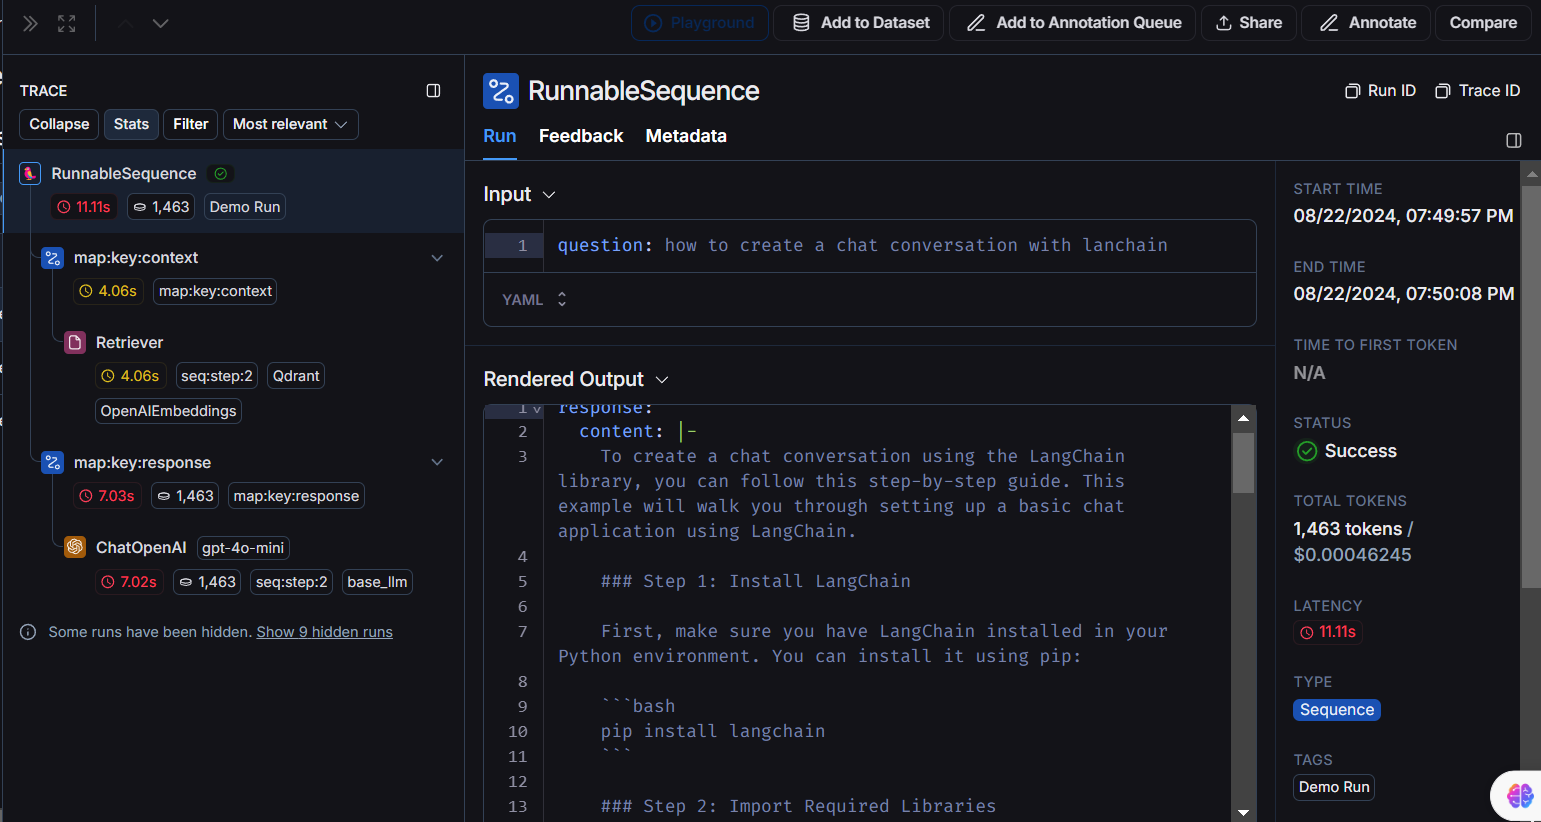


**Ollama embedding model metrics on Langsmith**
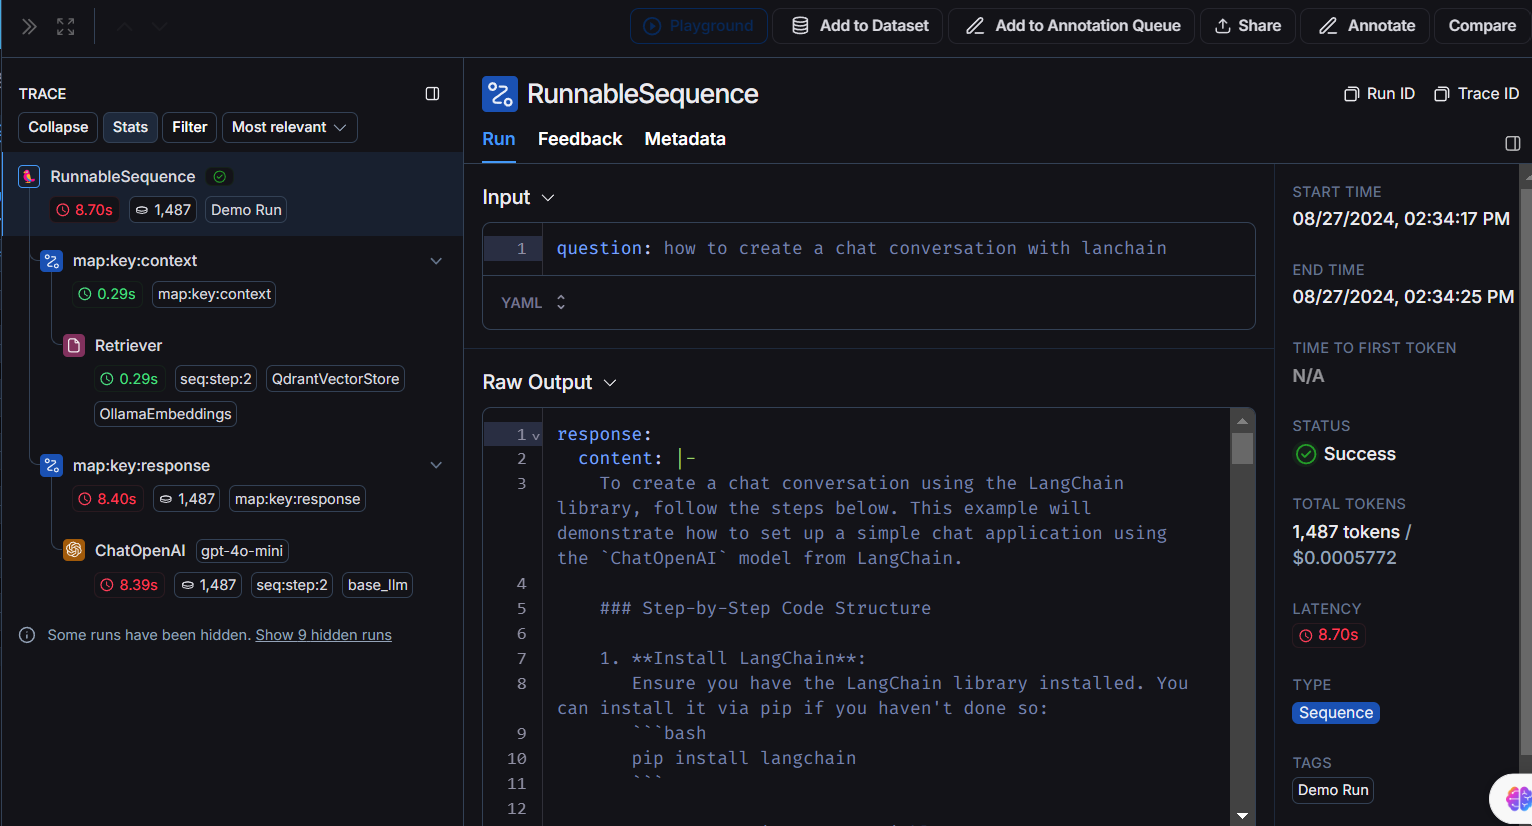


*regarding the metrcis in the screenshots, we can see that the more of them are about performance(Latency,cost,status) a trazability of the execution order of the subprocess. a good point of the metrcis is to integrate everything in one place, even easier that analyze them in the notebook or IDLE for Development.*

## Task 5: Loading Our Testing Set

In [18]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...


In [32]:
import pandas as pd

test_df = pd.read_csv("DataRepository/langchain_blog_test_data.csv")

Now we can set up our LangSmith client - and we'll add the above created dataset to our LangSmith instance!

> NOTE: Read more about this process [here](https://docs.smith.langchain.com/old/evaluation/faq/manage-datasets#create-from-list-of-values)

In [36]:
from langsmith import Client

client = Client()

dataset_name = "langsmith-demo-dataset-aie4-triples-v3"

dataset = client.create_dataset(
    dataset_name=dataset_name, description="LangChain Blog Test Questions"
)

for triplet in test_df.iterrows():
  triplet = triplet[1]
  client.create_example(
      inputs={"question" : triplet["question"], "context": triplet["context"]},
      outputs={"answer" : triplet["answer"]},
      dataset_id=dataset.id
  )

## Task 6: Evaluation

Now we can run the evaluation!

We'll need to start by preparing some custom data preparation functions to ensure our chain works with the expected inputs/outputs from the `evaluate` process in LangSmith.

> NOTE: More reading on this available [here](https://docs.smith.langchain.com/how_to_guides/evaluation/evaluate_llm_application#evaluate-a-langchain-runnable)

In [46]:
def prepare_data_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.outputs["answer"],
      "input" : example.inputs["question"]
  }

def prepare_data_noref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "input" : example.inputs["question"]
  }

def prepare_context_ref(run, example):
  return {
      "prediction" : run.outputs["response"],
      "reference" : example.inputs["context"],
      "input" : example.inputs["question"]
  }

We'll be using a few custom evaluators to evaluate our pipeline, as well as a few "built in" methods!

Check out the built-ins [here](https://docs.smith.langchain.com/reference/sdk_reference/langchain_evaluators)!

In [47]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

cot_qa_evaluator = LangChainStringEvaluator("cot_qa", prepare_data=prepare_context_ref)

unlabeled_dopeness_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria" : {
            "dopeness" : "Is the answer to the question dope, meaning cool - awesome - and legit?"
        }
    },
    prepare_data=prepare_data_noref
)

labeled_score_evaluator = LangChainStringEvaluator(
    "labeled_score_string",
    config={
        "criteria": {
            "accuracy": "Is the generated answer the same as the reference answer?"
        },
    },
    prepare_data=prepare_data_ref
)

base_rag_results = evaluate(
    retrieval_augmented_qa_chain.invoke,
    data=dataset_name,
    evaluators=[
        cot_qa_evaluator,
        unlabeled_dopeness_evaluator,
        labeled_score_evaluator,
        ],
    experiment_prefix="Base RAG Evaluation"
)

c:\Users\juanm\anaconda3\envs\llms\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


View the evaluation results for experiment: 'Base RAG Evaluation-b6fcc1a8' at:
https://smith.langchain.com/o/5fe1a158-f713-58b1-b71c-95fb6ac31e83/datasets/a0119b3f-7d1e-4885-9074-49c12a2f978b/compare?selectedSessions=cdec2aef-2795-4077-a5d5-8e868987a7a2




0it [00:00, ?it/s]Error running evaluator <DynamicRunEvaluator evaluate> on run 796f1e02-224d-44d9-82c2-5b1b79b21463: RateLimitError("Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-IqkrwDmcSaipPwtfndj1liLC on tokens per min (TPM): Limit 10000, Used 9674, Requested 900. Please try again in 3.444s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}")
Traceback (most recent call last):
  File "c:\Users\juanm\anaconda3\envs\llms\lib\site-packages\langsmith\evaluation\_runner.py", line 1266, in _run_evaluators
    evaluator_response = evaluator.evaluate_run(
  File "c:\Users\juanm\anaconda3\envs\llms\lib\site-packages\langsmith\evaluation\evaluator.py", line 278, in evaluate_run
    result = self.func(
  File "c:\Users\juanm\anaconda3\envs\llms\lib\site-packages\langsmith\run_helpers.py", line 603, in wrapper
    raise e
  File "c:\Users\juanm\anaconda3\envs\llms\l

#### ❓Question #1:

What conclusions can you draw about the above results?

Describe in your own words what the metrics are expressing.